<h1>Import necessary libraries</h1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU , ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from utils.callbacks import save_images, checkpoint_callback

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("using GPU")
    except RuntimeError as e:
        print(e)

using GPU


<h1>Load dataset</h1>

In [3]:
data_path = "data/"

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    label_mode=None, 
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1))

Found 21551 files belonging to 1 classes.


<h1>Define Model</h1>

In [5]:
init = tf.keras.initializers.RandomNormal(stddev=0.02)

In [6]:
def build_generator(seed_size):
    model = Sequential()
  
    model.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024))) 

    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())  

    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) 

    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) 

    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh'))

    return model

In [7]:
def build_discriminator(image_length,image_channels):
    model = Sequential()
  
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) #32,32,64

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) #16,16,128

    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) #8,8,256

    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) #4,4,512

    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

<h1>Define Loss</h1>

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

<h1>Define Train step</h1>

In [9]:
class DCGAN(keras.Model):
    def __init__(self,seed_size,image_length,image_channels,**kwargs):
        super(DCGAN,self).__init__(**kwargs)

        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length,image_channels)
        self.seed_size = seed_size
        
    def generator_loss(self,fake_output):
        # Train generator to give realistic images and penalize it for giving images being classified as fake by the discriminator
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self,real_output, fake_output,smooth=0.1):
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):
        if isinstance(data, tuple):
            data = data[0]
            
        batch_size = tf.shape(data)[0]
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            #generate image using generator
            generated_image = self.generator(seed, training = True)
        
            real_output = self.discriminator(data,training = True) #discriminator's prediction for real image
            fake_output = self.discriminator(generated_image,training = True) #discriminator's estimate for fake image
            
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            #optimize generator first
            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            #optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

<h1>Training</h1>

In [10]:
# parameters and hyperparameters
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

PREVIEW_ROWS = 4  
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

fixed_seed = tf.random.normal(shape=(PREVIEW_ROWS * PREVIEW_COLS, seed_size))

In [11]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

# create an object of the model
dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

The model uses two custom callbacks from the file located in "utils/callbacks.py"

In [12]:
with tf.device('/GPU:0'):
    #dcgan.generator.load_weights("Weights/generator_weights.h5")
    #dcgan.discriminator.load_weights("Weights/discriminator_weights.h5")
    history = dcgan.fit(train_ds,epochs=120,batch_size=batch_size,
                        callbacks=[
                            save_images(noise=fixed_seed,preview_rows=PREVIEW_ROWS,preview_cols=PREVIEW_COLS,preview_margin=PREVIEW_MARGIN),
                            checkpoint_callback()
                        ])

Epoch 1/120
169/169 [==============================] - 227s 1s/step - generator loss: 7.4267 - discriminator_loss: 1.6099
Epoch 2/120
169/169 [==============================] - 48s 286ms/step - generator loss: 2.2311 - discriminator_loss: 1.0806
Epoch 3/120
169/169 [==============================] - 48s 282ms/step - generator loss: 2.1657 - discriminator_loss: 1.0480
Epoch 4/120
169/169 [==============================] - 48s 283ms/step - generator loss: 1.9737 - discriminator_loss: 1.0672
Epoch 5/120
169/169 [==============================] - 48s 284ms/step - generator loss: 1.9824 - discriminator_loss: 1.1092
Epoch 6/120
169/169 [==============================] - 48s 285ms/step - generator loss: 1.9288 - discriminator_loss: 1.0903
Epoch 7/120
169/169 [==============================] - 48s 285ms/step - generator loss: 1.8793 - discriminator_loss: 1.1265
Epoch 8/120
169/169 [==============================] - 48s 282ms/step - generator loss: 1.8652 - discriminator_loss: 1.0902
Epoch 9/12

<h1>Testing</h1>

In [10]:
dcgan.generator.load_weights("Weights/generator_weights.h5")
dcgan.discriminator.load_weights("Weights/discriminator_weights.h5")

In [13]:
def generate_faces():
    noise = tf.random.normal([64,128])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

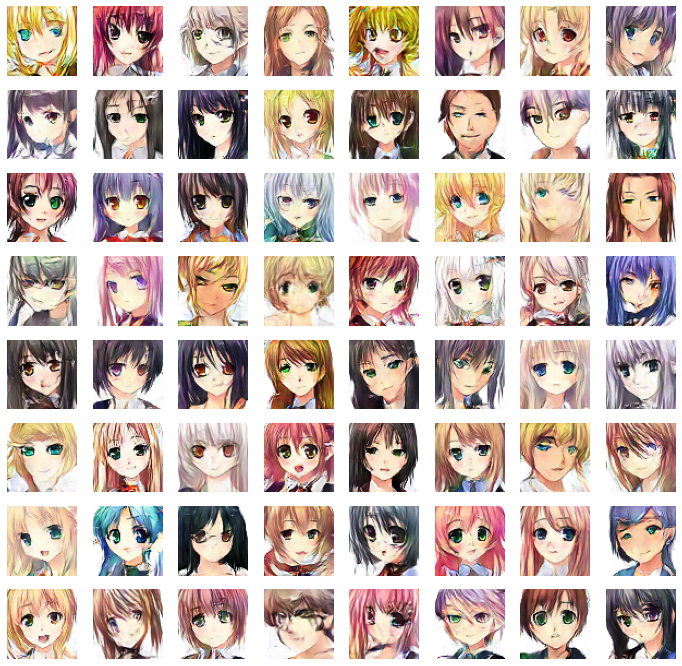

In [16]:
generate_faces()